# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

**Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type**. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that **predicts how much someone will spend based on demographics and offer type**. Or you could build a model that **predicts whether or not someone will respond to an offer**. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Set Overview

- The program used to create the data simulates how people make purchasing decisions and how those decisions are influenced by promotional offers.
- Each person in the simulation has some hidden traits that influence their purchasing patterns and are associated with their observable traits. People produce various events, including receiving offers, opening offers, and making purchases.
- As a simplification, there are no explicit products to track. Only the amounts of each transaction or offer are recorded.
- There are three types of offers that can be sent: **buy-one-get-one (BOGO), discount, and informational**. In a BOGO offer, a user needs to spend a certain amount to get a reward equal to that threshold amount. In a discount, a user gains a reward equal to a fraction of the amount spent. In an informational offer, there is no reward, but neither is there a requisite amount that the user is expected to spend. Offers can be delivered via multiple channels.
- The basic task is to use the data to identify which groups of people are most responsive to each type of offer, and how best to present each type of offer.

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  


# Table of Contents

I. [Data Exploration and cleaning](#Data-Exploration)<br>
II. [Feature Engineering of Promotion Lifecyle](#Feature-Engineering-promotion-lifecycle)<br>
III. [Data Vizualisation](#Dataviz)<br>
IV. [User-Item Collaborative Filtering with Funk SVD](#User-item)<br>

In [771]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
import time
from utils import *

In [772]:
% matplotlib inline

UsageError: Line magic function `%` not found.


In [798]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# <a class="anchor" id="Data-Exploration">Part I : Exploratory Data Analysis</a>

### 1. Portfolio table: only 10 lines since it is the repository for the transaction type

In [799]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [800]:
def clean_portfolio(portfolio):
    '''
    data cleaning the portfolio dataframe
    
    INPUT:
    portfolio - the portfolio dataframe to be cleaned
    
    OUTPUT:
    portfolio - the cleaned portfolio dataframe
    
    '''
    # change the duration from day to hour
    cleaned_portfolio = portfolio.copy()
    cleaned_portfolio['duration'] = cleaned_portfolio['duration'] * 24
    
    # apply one hot encoding to channels column
    cleaned_portfolio['web'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    cleaned_portfolio['email'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    cleaned_portfolio['mobile'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    cleaned_portfolio['social'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    # apply one hot encoding to offer_type column
    offer_type = pd.get_dummies(cleaned_portfolio['offer_type'])
    
    # drop the channels and offer_type column
    cleaned_portfolio.drop(['channels'], axis=1, inplace=True)
    
    # combine the portfolio and offer_type dataframe to form a cleaned dataframe
    cleaned_portfolio = pd.concat([cleaned_portfolio, offer_type], axis=1, sort=False)
    
    return cleaned_portfolio

In [801]:
cleaned_portfolio = clean_portfolio(portfolio)

In [802]:
cleaned_portfolio.head()

,reward,difficulty,duration,offer_type,id,web,email,mobile,social,bogo,discount,informational
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0


### 2. Profile table : basic statistics and feature engineering of dates

In [803]:
profile.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


In [804]:
profile.shape

(17000, 5)

In [805]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [806]:
sum(profile.age == 118)

2175

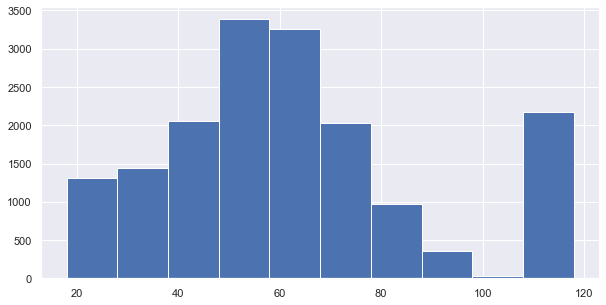

In [807]:
profile.age.hist();

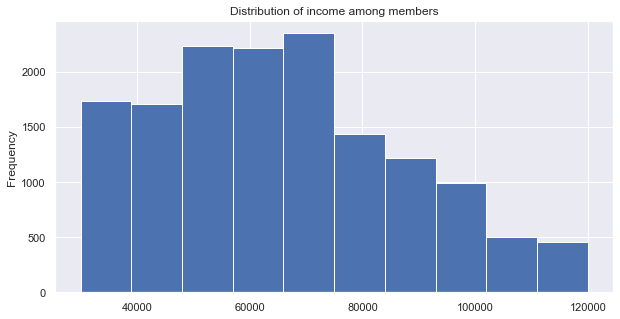

In [808]:
profile.income.plot(kind="hist",title="Distribution of income among members")

Text(0.5, 1.0, 'Distribution of age among members')

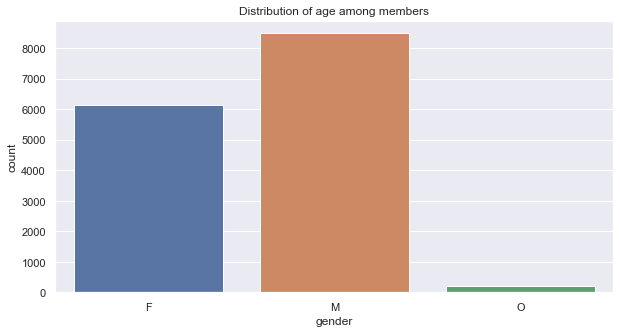

In [809]:
sns.set(rc={'figure.figsize':(10,5)})
sns.countplot(x='gender', data=profile).set_title("Distribution of age among members")

In [810]:
def clean_profile(profile):
    '''
    data cleaning the profile dataframe
    
    INPUT:
    profile - the profile dataframe to be cleaned
    
    OUTPUT:
    profile - the cleaned profile dataframe
    
    '''
    # age: (numeric) missing value encoded as 118
    profile['age'] = profile['age'].apply(lambda x: np.nan if x == 118 else x)
    
    # drop all missing values
    profile.dropna(inplace=True)
    
    # the number of days since the user is a memeber of starbucks
    profile['memberdays'] = pd.datetime.datetime.today().date() - pd.to_datetime(profile['became_member_on'], format='%Y%m%d').dt.date
    profile['memberdays'] = profile['memberdays'].dt.days
    
    
    return profile

In [811]:
cleaned_profile = clean_profile(profile)
cleaned_profile.head()

,gender,age,id,became_member_on,income,memberdays
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,1025
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0,1092
5,M,68.0,e2127556f4f64592b11af22de27a7932,20180426,70000.0,740
8,M,65.0,389bc3fa690240e798340f5a15918d5c,20180209,53000.0,816
12,M,58.0,2eeac8d8feae4a8cad5a6af0499a211d,20171111,51000.0,906


### 3. Transcript table

In [812]:
transcript[transcript.person=="78afa995795e4d85b5d9ceeca43f5fef"].head(10)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
15561,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},6
47582,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.89},132
47583,78afa995795e4d85b5d9ceeca43f5fef,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,132
49502,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 17.78},144
53176,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168
85291,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},216
87134,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 19.67},222
92104,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 29.72},240
141566,78afa995795e4d85b5d9ceeca43f5fef,transaction,{'amount': 23.93},378


Text(0.5, 1.0, 'Distribution of the different type of events')

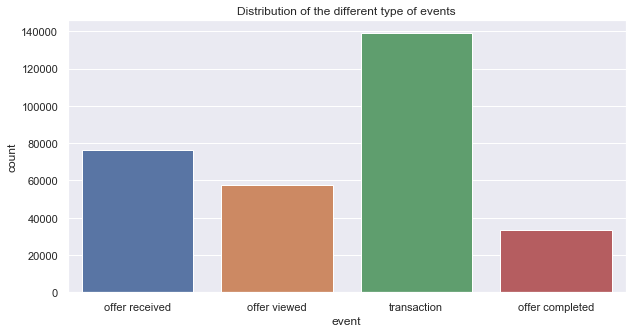

In [813]:
# Distribution of events
sns.countplot(x="event",data=transcript).set_title("Distribution of the different type of events")

In [814]:
# Feature Engineering of the value colum
def feature_column_offer_id(x):
    value = 0
    if "offer id" in x:
        value = x["offer id"]
    if "offer_id" in x:
        value = x["offer_id"]
    return value

def feature_column_amount(x):
    value = np.nan
    if "amount" in x:
        value = x["amount"]
    return value

transcript["offer_id"] = transcript["value"].apply(lambda x: feature_column_offer_id(x))
transcript["amount_spent"] = transcript["value"].apply(lambda x: feature_column_amount(x))

#transcript.drop(labels =["value"],axis=1)
transcript.head()

,person,event,value,time,offer_id,amount_spent
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [815]:
# Analysis of the offer
transcript.event.value_counts().index
offer_analysis = dict(zip(transcript.event.value_counts().index.tolist(),transcript.event.value_counts().values.tolist()))

transaction_viewed_pct = round(offer_analysis["offer viewed"]/offer_analysis["offer received"],2)
print("The share of offer viewed amnong the offer recieved is of {} %".format(transaction_viewed_pct*100))

transaction_completed_pct = round(offer_analysis["offer completed"]/offer_analysis["offer received"],2)
print("The share of offer completed amnong the offer recieved is of {} %".format(transaction_completed_pct*100))

The share of offer viewed amnong the offer recieved is of 76.0 %
The share of offer completed amnong the offer recieved is of 44.0 %


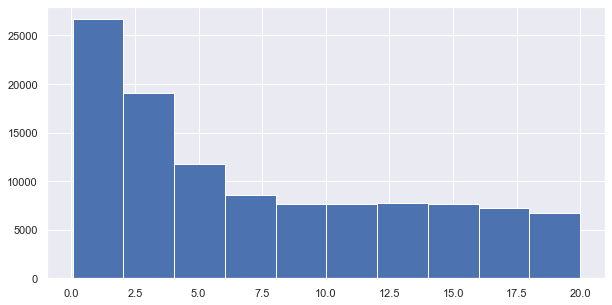

In [816]:
# Amount spent below 20 (since a maximum value above 1,000)
transcript["amount_spent"].loc[transcript.amount_spent<20].hist() 

# <a class="anchor" id="Feature-Engineering-promotion-lifecycle">Part II : Feature Engineering to understand the different promotion lifecyle and how they are related to existing transactions</a>

## 1. Test on some user_id

In [817]:
transcript.person.nunique()

17000

In [818]:
transcript.groupby('person').count()["event"].sort_values(ascending=False)

person
94de646f7b6041228ca7dec82adb97d2    51
8dbfa485249f409aa223a2130f40634a    49
79d9d4f86aca4bed9290350fb43817c2    48
d0a80415b84c4df4908b8403b19765e3    48
5e60c6aa3b834e44b822ea43a3efea26    48
                                    ..
22617705eec442e0b7b43e5c5f56fb17     2
df9fc9a86ca84ef5aedde8925d5838ba     2
3a4e53046c544134bb1e7782248631d1     2
e63e42480aae4ede9f07cac49c8c3f78     2
da7a7c0dcfcb41a8acc7864a53cf60fb     1
Name: event, Length: 17000, dtype: int64

In [822]:
user_id = "78afa995795e4d85b5d9ceeca43f5fef"

In [823]:
import utils as rf

In [824]:
offer_life_cycle_final,transaction_id_full = rf.extract_promo_information_and_related_transactions(transcript,user_id,portfolio)
offer_life_cycle_final.head(10)

,offer_id,creation_time,expiration_time,is_viewed,is_completed
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,168.0,1,1.0
1,5a8bc65990b245e5a138643cd4eb9837,168.0,240.0,1,NaN
2,ae264e3637204a6fb9bb56bc8210ddfd,408.0,576.0,1,1.0
3,f19421c1d4aa40978ebb69ca19b0e20d,504.0,624.0,1,1.0


In [825]:
rf.final_promotion_lifecycle(offer_life_cycle_final,transaction_id_full,user_id)

,offer_id,creation_time,expiration_time,is_viewed,is_completed,mean_amount_spent,total_amount_spent
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,168.0,1.0,1.0,19.890000,19.89
1,5a8bc65990b245e5a138643cd4eb9837,168.0,240.0,1.0,NaN,24.695000,49.39
2,ae264e3637204a6fb9bb56bc8210ddfd,408.0,576.0,1.0,1.0,21.720000,21.72
3,f19421c1d4aa40978ebb69ca19b0e20d,504.0,624.0,1.0,1.0,NaN,NaN
4,0,0.0,0.0,NaN,NaN,22.756667,68.27


## 2. Loops on the overall transcript tables

In [24]:
# Initialization
import utils as rf
user_id_init = "94de646f7b6041228ca7dec82adb97d2"
offer_life_cycle_final,transaction_id_full = rf.extract_promo_information_and_related_transactions(transcript,user_id_init,portfolio)
offer_life_cycle_final_all = rf.final_promotion_lifecycle(offer_life_cycle_final,transaction_id_full,user_id_init)
user_promotion_cycle = offer_life_cycle_final_all

In [25]:
user_promotion_cycle.head(10)

,offer_id,creation_time,expiration_time,is_viewed,is_completed,mean_amount_spent,total_amount_spent
0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,120.0,1.0,1.0,7.410000,7.41
1,9b98b8c7a33c4b65b9aebfe6a799e6d9,168.0,336.0,1.0,1.0,2.795000,16.77
2,0b1e1539f2cc45b7b9fa7c272da2e1d7,336.0,576.0,NaN,1.0,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,408.0,648.0,1.0,1.0,5.505000,11.01
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,504.0,672.0,1.0,1.0,2.345000,14.07
5,4d5c57ea9a6940dd891ad53e9dbe8da0,576.0,696.0,1.0,NaN,2.413333,14.48
6,0,0.0,0.0,NaN,NaN,1.892143,26.49


In [26]:
user_promotion_cycle,non_working_user_id = rf.building_user_promotion_cycle(transcript,portfolio,user_id_init,300)

It takes 0.2858314832051595 mins to make 100 batch of iterations
It takes 0.5766298015912373 mins to make 200 batch of iterations
It takes 0.8748680671056112 mins to make 300 batch of iterations


In [27]:
user_promotion_cycle.head()

,offer_id,creation_time,expiration_time,is_viewed,is_completed,mean_amount_spent,total_amount_spent,user_id
0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,168.0,1.0,1.0,20.56,20.56,2f888cf4ae2f40429917e7c7c41fff40
1,2298d6c36e964ae4a3e7e9706d1fb8c2,336.0,504.0,1.0,1.0,10.20,10.20,2f888cf4ae2f40429917e7c7c41fff40
2,9b98b8c7a33c4b65b9aebfe6a799e6d9,408.0,576.0,1.0,1.0,23.02,23.02,2f888cf4ae2f40429917e7c7c41fff40
3,2906b810c7d4411798c6938adc9daaa5,504.0,672.0,1.0,1.0,15.13,15.13,2f888cf4ae2f40429917e7c7c41fff40
4,f19421c1d4aa40978ebb69ca19b0e20d,576.0,696.0,1.0,1.0,26.09,26.09,2f888cf4ae2f40429917e7c7c41fff40


## 3. Save the final table: it took more than 80 minutes to loop on the overall transcript table

import pickle
user_promotion_cycle.to_pickle("data/user_promotion_cycle_version_withoutexpection.pkl")

user_promotion_cycle.user_id.nunique()/user_promotion_cycle.person.nunique() #73% of person_id, errors for the remaining ones

## 4. Reproduce the loops by distinguishing training and tests data

In [595]:
# Approximate split between train and test: 
train_size = int(transcript.shape[0]*0.7)
transcript_train = transcript.iloc[:train_size]
print(transcript_train.shape)
transcript_test = transcript.iloc[train_size+1:]
print(transcript_test.shape)

(214573, 6)
(91960, 6)


In [596]:
last_time_training = transcript_train.time.iloc[-1]
print("the last time in the training set is {}".format(last_time_training))

the last time in the training set is 504


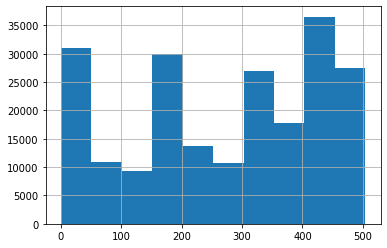

In [597]:
transcript_train["time"].hist();

In [598]:
# Adjusting train and test split (according to the last time in the training set)
transcript_train_true = transcript[transcript.time<=last_time_training]
transcript_test_true = transcript[transcript.time>last_time_training]

print("the real split between train and test is of {} %".format(transcript_train_true.shape[0]/transcript.shape[0]))

the real split between train and test is of 0.7124560407654615 %


In [599]:
# Load in the overall user_promotion_cycle dataframe
df_user_promotion_cycle = pd.read_pickle("data/user_promotion_cycle_version_withoutexpection.pkl").reset_index()
df_user_promotion_cycle.head(10)

,index,offer_id,creation_time,expiration_time,is_viewed,is_completed,mean_amount_spent,total_amount_spent,user_id
0,0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,168.0,1.0,NaN,2.293333,6.88,1e41c43e184e46759f01317e69f5cfcd
1,1,3f207df678b143eea3cee63160fa8bed,168.0,264.0,NaN,NaN,NaN,NaN,1e41c43e184e46759f01317e69f5cfcd
2,2,2906b810c7d4411798c6938adc9daaa5,336.0,504.0,NaN,NaN,NaN,NaN,1e41c43e184e46759f01317e69f5cfcd
3,3,f19421c1d4aa40978ebb69ca19b0e20d,504.0,624.0,1.0,1.0,8.350000,8.35,1e41c43e184e46759f01317e69f5cfcd
4,4,3f207df678b143eea3cee63160fa8bed,576.0,672.0,NaN,NaN,NaN,NaN,1e41c43e184e46759f01317e69f5cfcd
5,5,0,0.0,0.0,NaN,NaN,7.420000,14.84,1e41c43e184e46759f01317e69f5cfcd
6,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,120.0,1.0,NaN,NaN,NaN,c7c576f3711d48c6856abe45f952a8f5
7,1,3f207df678b143eea3cee63160fa8bed,168.0,264.0,NaN,NaN,NaN,NaN,c7c576f3711d48c6856abe45f952a8f5
8,2,0b1e1539f2cc45b7b9fa7c272da2e1d7,336.0,576.0,1.0,1.0,32.990000,32.99,c7c576f3711d48c6856abe45f952a8f5
9,3,3f207df678b143eea3cee63160fa8bed,408.0,504.0,NaN,NaN,NaN,NaN,c7c576f3711d48c6856abe45f952a8f5


In [600]:
# Split according to the last_time_training
user_promotion_cycle_training = df_user_promotion_cycle[df_user_promotion_cycle.creation_time<=last_time_training]
user_promotion_cycle_test = df_user_promotion_cycle[df_user_promotion_cycle.creation_time>last_time_training]

In [601]:
user_promotion_cycle_training.shape

(59694, 9)

In [602]:
user_promotion_cycle_test.shape

(9611, 9)

In [603]:
# Identify the user that are in the test set while not being part of the training set
train_idx = set(user_promotion_cycle_training.user_id)
test_idx = set(user_item_test.index)
match_idx = list(test_idx.intersection(train_idx))
cold_start_idx = np.setdiff1d(match_idx, list(test_idx), assume_unique=True)
print(len(cold_start_idx))

0


# <a class="anchor" id="Dataviz">Part III : Data Vizualisation of response to promotions per demographics or channel of communication</a>

## O. Load the final overall table

In [657]:
labels_to_drop = ["creation_time","expiration_time"]
df_user_promotion_cycle = pd.read_pickle("data/user_promotion_cycle_version_withoutexpection.pkl").drop(labels=labels_to_drop,axis=1)
df_user_promotion_cycle.head()

,offer_id,is_viewed,is_completed,mean_amount_spent,total_amount_spent,user_id
0,ae264e3637204a6fb9bb56bc8210ddfd,1.0,NaN,2.293333,6.88,1e41c43e184e46759f01317e69f5cfcd
1,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,NaN,1e41c43e184e46759f01317e69f5cfcd
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN,NaN,1e41c43e184e46759f01317e69f5cfcd
3,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,8.350000,8.35,1e41c43e184e46759f01317e69f5cfcd
4,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,NaN,1e41c43e184e46759f01317e69f5cfcd


In [658]:
df_user_promotion_cycle.user_id.nunique()/transcript.person.nunique()

0.727764705882353

## 1. Enriched df_user_promotion_cycle table with user and promotion information

In [659]:
cleaned_portfolio.head()

,reward,difficulty,duration,offer_type,id,web,email,mobile,social,bogo,discount,informational
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0


In [752]:
# Join with portfolio data
labels_to_drop = ["duration","id"]
df_user_promotion_cycle_enriched = pd.merge(df_user_promotion_cycle,cleaned_portfolio,left_on = "offer_id",right_on="id",how="left").drop(labels=labels_to_drop,axis=1)
df_user_promotion_cycle_enriched.head()

,offer_id,is_viewed,is_completed,mean_amount_spent,total_amount_spent,user_id,reward,difficulty,offer_type,web,email,mobile,social,bogo,discount,informational
0,ae264e3637204a6fb9bb56bc8210ddfd,1.0,NaN,2.293333,6.88,1e41c43e184e46759f01317e69f5cfcd,10.0,10.0,bogo,0.0,1.0,1.0,1.0,1.0,0.0,0.0
1,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,NaN,1e41c43e184e46759f01317e69f5cfcd,0.0,0.0,informational,1.0,1.0,1.0,0.0,0.0,0.0,1.0
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN,NaN,1e41c43e184e46759f01317e69f5cfcd,2.0,10.0,discount,1.0,1.0,1.0,0.0,0.0,1.0,0.0
3,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,8.350000,8.35,1e41c43e184e46759f01317e69f5cfcd,5.0,5.0,bogo,1.0,1.0,1.0,1.0,1.0,0.0,0.0
4,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,NaN,1e41c43e184e46759f01317e69f5cfcd,0.0,0.0,informational,1.0,1.0,1.0,0.0,0.0,0.0,1.0


In [753]:
df_user_promotion_cycle_enriched["offer_type"].value_counts()

discount         23511
bogo             22765
informational    10657
Name: offer_type, dtype: int64

In [754]:
# Join with profile data
df_user_promotion_cycle_enriched_final = pd.merge(df_user_promotion_cycle_enriched,cleaned_profile,left_on = "user_id",right_on="id",how="left")
df_user_promotion_cycle_enriched_final.head(5)

,offer_id,is_viewed,is_completed,mean_amount_spent,total_amount_spent,user_id,reward,difficulty,offer_type,web,...,social,bogo,discount,informational,gender,age,id,became_member_on,income,memberdays
0,ae264e3637204a6fb9bb56bc8210ddfd,1.0,NaN,2.293333,6.88,1e41c43e184e46759f01317e69f5cfcd,10.0,10.0,bogo,0.0,...,1.0,1.0,0.0,0.0,M,57.0,1e41c43e184e46759f01317e69f5cfcd,20180305.0,46000.0,791.0
1,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,NaN,1e41c43e184e46759f01317e69f5cfcd,0.0,0.0,informational,1.0,...,0.0,0.0,0.0,1.0,M,57.0,1e41c43e184e46759f01317e69f5cfcd,20180305.0,46000.0,791.0
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN,NaN,1e41c43e184e46759f01317e69f5cfcd,2.0,10.0,discount,1.0,...,0.0,0.0,1.0,0.0,M,57.0,1e41c43e184e46759f01317e69f5cfcd,20180305.0,46000.0,791.0
3,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,8.350000,8.35,1e41c43e184e46759f01317e69f5cfcd,5.0,5.0,bogo,1.0,...,1.0,1.0,0.0,0.0,M,57.0,1e41c43e184e46759f01317e69f5cfcd,20180305.0,46000.0,791.0
4,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,NaN,1e41c43e184e46759f01317e69f5cfcd,0.0,0.0,informational,1.0,...,0.0,0.0,0.0,1.0,M,57.0,1e41c43e184e46759f01317e69f5cfcd,20180305.0,46000.0,791.0


In [764]:
dict_new_name = {}
for i,v in cleaned_portfolio.iterrows():
    dict_new_name[v["id"]]=str(v["offer_type"])+"_"+str(v["reward"])+"_"+str(v["difficulty"])+"_"+str(v["duration"])

In [765]:
dict_new_name

{'ae264e3637204a6fb9bb56bc8210ddfd': 'bogo_10_10_168',
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 'bogo_10_10_120',
 '3f207df678b143eea3cee63160fa8bed': 'informational_0_0_96',
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 'bogo_5_5_168',
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 'discount_5_20_240',
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 'discount_3_7_168',
 'fafdcd668e3743c1bb461111dcafc2a4': 'discount_2_10_240',
 '5a8bc65990b245e5a138643cd4eb9837': 'informational_0_0_72',
 'f19421c1d4aa40978ebb69ca19b0e20d': 'bogo_5_5_120',
 '2906b810c7d4411798c6938adc9daaa5': 'discount_2_10_168'}

In [766]:
df_user_promotion_cycle_enriched_final["offer_id_name"] = df_user_promotion_cycle_enriched_final["offer_id"].map(dict_new_name)
df_user_promotion_cycle_enriched_final.head()

,offer_id,is_viewed,is_completed,mean_amount_spent,total_amount_spent,user_id,reward,difficulty,offer_type,web,...,bogo,discount,informational,gender,age,id,became_member_on,income,memberdays,offer_id_name
0,ae264e3637204a6fb9bb56bc8210ddfd,1.0,NaN,2.293333,6.88,1e41c43e184e46759f01317e69f5cfcd,10.0,10.0,bogo,0.0,...,1.0,0.0,0.0,M,57.0,1e41c43e184e46759f01317e69f5cfcd,20180305.0,46000.0,791.0,bogo_10_10_168
1,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,NaN,1e41c43e184e46759f01317e69f5cfcd,0.0,0.0,informational,1.0,...,0.0,0.0,1.0,M,57.0,1e41c43e184e46759f01317e69f5cfcd,20180305.0,46000.0,791.0,informational_0_0_96
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN,NaN,1e41c43e184e46759f01317e69f5cfcd,2.0,10.0,discount,1.0,...,0.0,1.0,0.0,M,57.0,1e41c43e184e46759f01317e69f5cfcd,20180305.0,46000.0,791.0,discount_2_10_168
3,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,8.350000,8.35,1e41c43e184e46759f01317e69f5cfcd,5.0,5.0,bogo,1.0,...,1.0,0.0,0.0,M,57.0,1e41c43e184e46759f01317e69f5cfcd,20180305.0,46000.0,791.0,bogo_5_5_120
4,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,NaN,1e41c43e184e46759f01317e69f5cfcd,0.0,0.0,informational,1.0,...,0.0,0.0,1.0,M,57.0,1e41c43e184e46759f01317e69f5cfcd,20180305.0,46000.0,791.0,informational_0_0_96


In [909]:
# Replace the Nan offer type by the transaction 
df_user_promotion_cycle_enriched_final.loc[df_user_promotion_cycle_enriched_final.offer_type.isnull()==True,"offer_type"] = "transaction"
df_user_promotion_cycle_enriched_final.head()

,offer_id,is_viewed,is_completed,mean_amount_spent,total_amount_spent,user_id,reward,difficulty,offer_type,web,...,bogo,discount,informational,gender,age,id,became_member_on,income,memberdays,offer_id_name
0,ae264e3637204a6fb9bb56bc8210ddfd,1.0,NaN,2.293333,6.88,1e41c43e184e46759f01317e69f5cfcd,10.0,10.0,bogo,0.0,...,1.0,0.0,0.0,M,57.0,1e41c43e184e46759f01317e69f5cfcd,20180305.0,46000.0,791.0,bogo_10_10_168
1,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,NaN,1e41c43e184e46759f01317e69f5cfcd,0.0,0.0,informational,1.0,...,0.0,0.0,1.0,M,57.0,1e41c43e184e46759f01317e69f5cfcd,20180305.0,46000.0,791.0,informational_0_0_96
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN,NaN,1e41c43e184e46759f01317e69f5cfcd,2.0,10.0,discount,1.0,...,0.0,1.0,0.0,M,57.0,1e41c43e184e46759f01317e69f5cfcd,20180305.0,46000.0,791.0,discount_2_10_168
3,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,8.350000,8.35,1e41c43e184e46759f01317e69f5cfcd,5.0,5.0,bogo,1.0,...,1.0,0.0,0.0,M,57.0,1e41c43e184e46759f01317e69f5cfcd,20180305.0,46000.0,791.0,bogo_5_5_120
4,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,NaN,1e41c43e184e46759f01317e69f5cfcd,0.0,0.0,informational,1.0,...,0.0,0.0,1.0,M,57.0,1e41c43e184e46759f01317e69f5cfcd,20180305.0,46000.0,791.0,informational_0_0_96


In [910]:
df_user_promotion_cycle_enriched_final.offer_type.value_counts()

discount         23511
bogo             22765
transaction      12372
informational    10657
Name: offer_type, dtype: int64

df_user_promotion_cycle_enriched_final["offer_id_name"] = np.nan
df_user_promotion_cycle_enriched_final["viewed_amount_spent"] = np.nan

for i,v in df_user_promotion_cycle_enriched_final.iterrows():
    df_user_promotion_cycle_enriched_final.loc[i,"offer_id_name"]= rename_offer(v)
    df_user_promotion_cycle_enriched_final.loc["viewed_amount_spent"]= ((v["is_viewed"]>0)&(v["total_amount_spent"]>0))

## 2. Data Viz to analyse the impact of offers on cash inflows, and the influence of social demographics and promotion channels towards promotion efficiency

Text(0.5, 1.0, 'Distribution of Cash inflows')

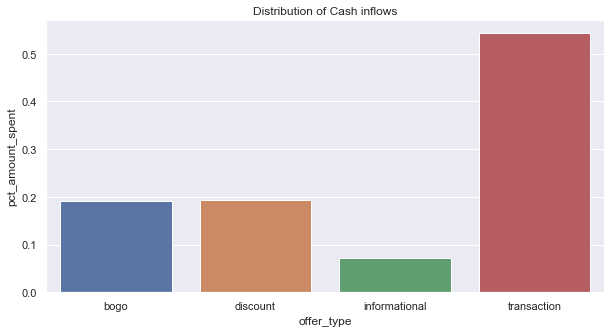

In [922]:
# Plot the percentage of cash inflows
df_plot0 = pd.DataFrame(df_user_promotion_cycle_enriched_final.groupby("offer_type")["total_amount_spent"].sum()).reset_index()
df_plot0["pct_amount_spent"] = df_plot0["total_amount_spent"]/df_plot0.total_amount_spent.sum()
sns.set(rc={'figure.figsize':(10,5)})
sns.barplot(x="offer_type", y="pct_amount_spent", data=df_plot0).set_title("Distribution of Cash inflows")

In [921]:
df_plot0

,offer_type,total_amount_spent,pct_amount_spent
0,bogo,319719.78,0.190707
1,discount,325619.64,0.194226
2,informational,121174.11,0.072278
3,transaction,909986.87,0.542790


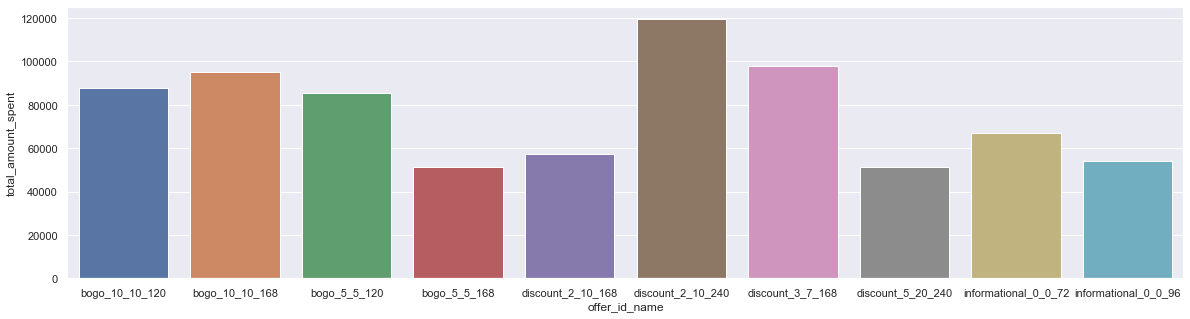

In [893]:
# Plot the distribution of the overall spent per offer
df_plot1 = pd.DataFrame(df_user_promotion_cycle_enriched_final.groupby(["offer_id_name"])["total_amount_spent"].sum()).reset_index()
#df_plot1["pct_amount_spent"] =df_agg1["total_amount_spent"]/df_agg1.total_amount_spent.sum()
sns.set(rc={'figure.figsize':(20,5)})
sns.barplot(x="offer_id_name", y="total_amount_spent", data=df_plot1)

In [894]:
# Plot the distribution of the overall spent per type of offer and per gender
df_plot1 = pd.DataFrame(df_user_promotion_cycle_enriched_final.groupby(["offer_type","gender"])["total_amount_spent"].sum()).reset_index()
#df_plot1["pct_amount_spent"] =df_agg1["total_amount_spent"]/df_agg1.total_amount_spent.sum()
df_plot1.head()

,offer_type,gender,total_amount_spent
0,bogo,F,153365.96
1,bogo,M,153893.88
2,bogo,O,4649.87
3,discount,F,153132.60
4,discount,M,156698.45


Text(0.5, 1.0, 'Distribution of spent amount per offer and gender')

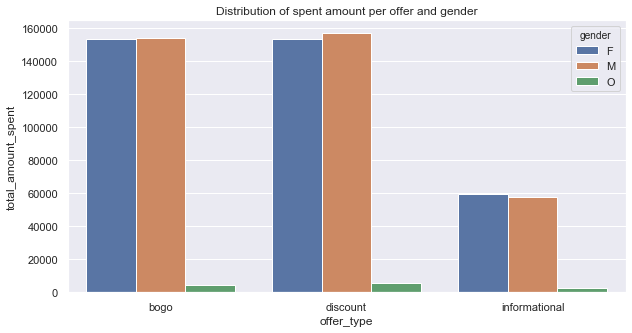

In [923]:
sns.barplot(x="offer_type", y="total_amount_spent", hue="gender", data=df_plot1).set_title("Distribution of spent amount per offer and gender")

Text(0.5, 1.0, 'Distribution of offer per channel and per gender')

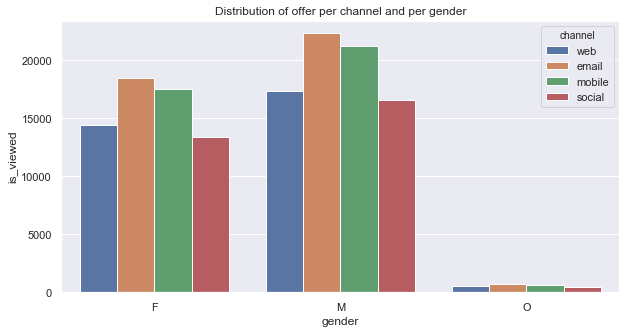

In [924]:
# Plot the distribution of the viewed offer per channel and per gender

channel_distribution = pd.DataFrame(df_user_promotion_cycle_enriched_final[df_user_promotion_cycle_enriched_final["web"] ==1].groupby(["gender"])["is_viewed"].count()).reset_index()
channel_distribution["channel"]="web"


for channel_type in ['email', 'mobile', 'social']:
    df_channel = pd.DataFrame()
    df_channel = pd.DataFrame(df_user_promotion_cycle_enriched_final[df_user_promotion_cycle_enriched_final[channel_type] ==1].groupby(["gender"])["is_viewed"].count()).reset_index()
    df_channel["channel"]=channel_type
    channel_distribution = pd.concat([channel_distribution,df_channel])
#channel_distribution["is_viewed"] =channel_distribution["is_viewed"]/channel_distribution.is_viewed.sum()
sns.barplot(x="gender", y="is_viewed", hue="channel", data=channel_distribution).set_title("Distribution of offer per channel and per gender")


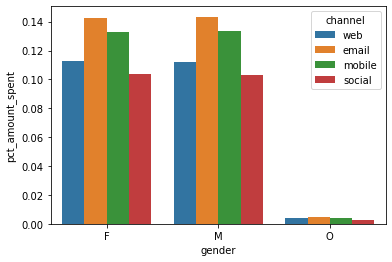

In [716]:
# Plot the distribution of the spent amount per channel and per gender for received and viewed offer

channel_distribution = pd.DataFrame(df_user_promotion_cycle_enriched_final[df_user_promotion_cycle_enriched_final["web"] ==1].groupby(["gender"])["total_amount_spent"].sum()).reset_index()
channel_distribution["channel"]="web"


for channel_type in ['email', 'mobile', 'social']:
    df_channel = pd.DataFrame()
    df_channel = pd.DataFrame(df_user_promotion_cycle_enriched_final[df_user_promotion_cycle_enriched_final[channel_type] ==1].groupby(["gender"])["total_amount_spent"].sum()).reset_index()
    df_channel["channel"]=channel_type
    channel_distribution = pd.concat([channel_distribution,df_channel])
channel_distribution["pct_amount_spent"] =channel_distribution["total_amount_spent"]/channel_distribution.total_amount_spent.sum()
sns.barplot(x="gender", y="pct_amount_spent", hue="channel", data=channel_distribution)


In [ ]:
# Plot the percentage of customer response (viewed and completed, or viewed and spent amount) to BOGO and discount offer
df_plot1 = 

In [ ]:
# Plot the percentage of customer response (viewed and completed, or viewed and spent amount) to BOGO and discount offer for every promotion channel


In [ ]:
# Plot total spent distribution across received and seen promotions

# <a class="anchor" id="User-item">Part IV : User-Item recommendation leveraging on Funk SVD </a>

## 1. Build the user-item matrix

### Option 1 : Build the user-item matrix by searching for the record pattern: offer received, offer viewed, offer completed

In [604]:
def pattern_received_viewed_completed(row):
    '''
    INPUT : row (Series): row of the df_user_promotion_cycle_final dataframe
    OUTPUT : pattern (int): value of the recorded pattern (offer received, offer viewed, offer completed): 1: if the record pattern is matched, 0 else
    '''
    pattern = 0
    if ( (row.is_viewed>0) & (row.is_completed>0) )==True:
        pattern =1
   
    return pattern

### Option 2 : Build the user-item matrix by searching for more advanced record pattern: 
- If viewed and completed: 2
- If not viewed and completed : 0
- If viewed and not completed : -1
- If viewed and no transaction: -2

In [605]:
def pattern_advanced(row,spent_treshold):
    '''
    INPUT : row (Series): row of the df_user_promotion_cycle_final dataframe
    OUTPUT : pattern (int): value of the recorded pattern (offer received, offer viewed, 
    offer completed)
    '''
    pattern = np.nan
    if row.is_viewed >0:
        if row.is_completed >0:
            pattern = 2
        else :
            if row.total_amount_spent>spent_treshold:
                pattern = -1
            else :
                pattern = -2
                
    if (row.is_viewed==0) & (row.is_completed>0): 
        pattern =0   
    
    return pattern

### User-item matrix

In [606]:
def user_item_matrix(user_promotion_cycle,option="option1"):
    '''
    Build the user item matrix depending on the chosen option
    INPUT:
    - user_promotion_cycle_final (dataframe): promotion lifecycle for each user
    - Option (string): option chosen to build the user-item matrix (cf. above for more details), can take two values: "option1" or "option2"
    '''
    df_user_promotion_cycle_final = user_promotion_cycle.copy()
      
    if option == "option1":
        df_user_promotion_cycle_final.loc[:,"viewed_and_completed"] = [0]*df_user_promotion_cycle_final.shape[0]
        for i,v in df_user_promotion_cycle_final.iterrows():
            df_user_promotion_cycle_final.loc[i,"viewed_and_completed"] = pattern_received_viewed_completed(v)
        
        # Build the user-item matrix and drop column corresponding to no offer
        # For every pair (user, offer) take the maximum value 
        user_item = df_user_promotion_cycle_final.groupby(["user_id","offer_id"])["viewed_and_completed"].max().unstack()
        
        
    if option =="option2":
        df_user_promotion_cycle_final["advanced_pattern"] = [np.nan]*df_user_promotion_cycle_final.shape[0]
        for i,v in df_user_promotion_cycle_final.iterrows():
            df_user_promotion_cycle_final.loc[i,"advanced_pattern"] = pattern_advanced(v,1)
         # For every pair (user, offer) take the maximum value 
        user_item = df_user_promotion_cycle_final.groupby(["user_id","offer_id"])["advanced_pattern"].max().unstack()

    return user_item,df_user_promotion_cycle_final

In [608]:
# Save training and test table for "option1"
user_item_training_opt1,df_user_promotion_cycle_final_training = user_item_matrix(user_promotion_cycle_training,"option1")
user_item_test_opt1,_ = user_item_matrix(user_promotion_cycle_test,option="option1")

import pickle
user_item_training_opt1.to_pickle("data/user_item_training_opt1.pkl")
user_item_test_opt1.to_pickle("data/user_item_test_opt1.pkl")

In [609]:
# Save training and test table for "option2"
user_item_training_opt2,df_user_promotion_cycle_final_training_2 = user_item_matrix(user_promotion_cycle_training,option="option2")
user_item_test_opt2,_ = user_item_matrix(user_promotion_cycle_test,option="option2")

import pickle
user_item_training_opt2.to_pickle("data/user_item_training_opt2.pkl")
user_item_test_opt2.to_pickle("data/user_item_test_opt2.pkl")

In [826]:
# Check for data existence
user_item_test_opt1.head(10)

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
user_id,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00426fe3ffde4c6b9cb9ad6d077a13ea,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
004b041fbfe44859945daa2c7f79ee64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
004c5799adbf42868b9cff0396190900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
005500a7188546ff8a767329a2f7c76a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN
0056df74b63b4298809f0b375a304cf4,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0069a50874d846438e58acff5e594725,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00715b6e55c3431cb56ff7307eb19675,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00840a2ca5d2408e982d56544dc14ffd,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [611]:
# Check for data existence
user_item_test_opt2.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
user_id,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00426fe3ffde4c6b9cb9ad6d077a13ea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
004b041fbfe44859945daa2c7f79ee64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
004c5799adbf42868b9cff0396190900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
005500a7188546ff8a767329a2f7c76a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN


## 2. Implement Funk SVD and fit to the training set for option 1

In [857]:
# Function taken from the recommendation Lesson in Udacity Term2
def FunkSVD(ratings_mat,user_item_test,latent_features=4, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    ratings_mat - (numpy array) a matrix with users as rows, promotions as columns, and matched pattern as values
    user_item_test (dataframe) - user item test dataframe to evaluate the metrics
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    movie_mat - (numpy array) a latent feature by movie matrix
    mse (float): last iteration total mean squared error of the prediction vs. true value
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = ratings_mat.shape[0]
    n_movies = ratings_mat.shape[1]
    num_ratings = np.count_nonzero(~np.isnan(ratings_mat))
    
    # initialize the user and movie matrices with random values
    user_mat = np.random.rand(n_users, latent_features)
    movie_mat = np.random.rand(latent_features, n_movies)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    mse_iter =[]
    test_mse_iter =[]
    
    # keep track of iteration and MSE
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        mse =0
        
        # For each user-movie pair
        for i in range(n_users):
            for j in range(n_movies):
                
                # if the rating exists
                if ratings_mat[i, j] > 0:
                    
                    # compute the error as the actual minus the dot product of the user and movie latent features
                    diff = ratings_mat[i, j] - np.dot(user_mat[i, :], movie_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*movie_mat[k, j])
                        movie_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])
        
       
        
        # print results
        if iteration % 20 ==0 :
            print("%d \t\t %f" % (iteration+1, sse_accum / num_ratings))
        
        offer_mat = movie_mat
        mse = sse_accum / num_ratings
        mse_iter.append(mse)
        test_mse_iter.append(validation_new(user_item_test, user_mat, movie_mat))
               
    return user_mat, offer_mat, mse_iter,test_mse_iter

In [830]:
# Statistics on the user-item matrix
1- np.count_nonzero(~np.isnan(user_item_train))/(user_item_train.shape[0]*user_item_train.shape[1])
np.count_nonzero(np.where(user_item_train==1))
np.count_nonzero(np.where(user_item_train==0))

0.6206838021338505

In [846]:
# Load user_item build on the training set
user_item_train = pd.read_pickle("data/user_item_training_opt1.pkl").drop(labels=[0.0],axis=1)
user_item_train.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,3f207df678b143eea3cee63160fa8bed,4d5c57ea9a6940dd891ad53e9dbe8da0,5a8bc65990b245e5a138643cd4eb9837,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
user_id,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1.0,1.0
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,NaN,0.0,NaN,0.0,1.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,NaN,1.0,0.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,NaN,0.0,1.0,NaN,1.0,NaN
003d66b6608740288d6cc97a6903f4f0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,1.0


In [865]:
train_data_np = np.array(user_item_train)

# Fit FunkSVD with the specified hyper parameters to the training data
user_mat, offer_mat,mse,test_mse = FunkSVD(train_data_np,user_item_test,latent_features=15, learning_rate=0.005, iters=100)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.042230
21 		 0.008844
41 		 0.007128
61 		 0.005790
81 		 0.004739


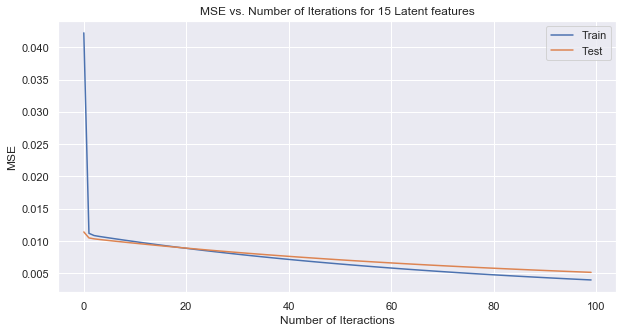

In [881]:
iters = 100
plt.plot(range(iters),mse,label='Train');
plt.plot(range(iters),test_mse,label='Test');

plt.xlabel('Number of Iteractions');
plt.ylabel('MSE');
plt.title('MSE vs. Number of Iterations for 15 Latent features');
plt.legend();

In [884]:
# Check for coherence
validation_new(user_item_train, user_mat, offer_mat)

0.003913465228051029

In [889]:
test_mse[-1]

0.005124532785834487

In [876]:
# Test for the best number of latent feature. (with latent features 10)
user_mat_10, offer_mat_10,mse_10,test_mse_10  = FunkSVD(train_data_np, user_item_test,latent_features=10, learning_rate=0.005, iters=100)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.037632
21 		 0.011945
41 		 0.008802
61 		 0.006590
81 		 0.005010


In [890]:
test_mse_10[-1]

0.006065218712835692

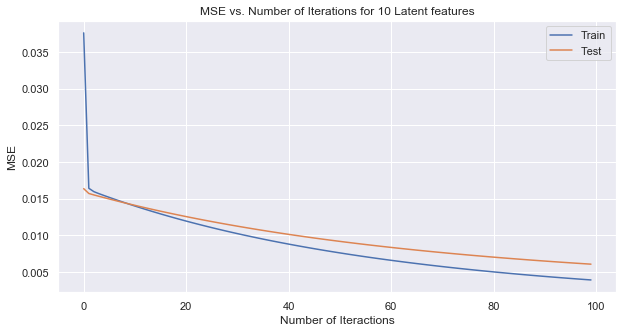

In [882]:
iters = 100
plt.plot(range(iters),mse_10,label='Train');
plt.plot(range(iters),test_mse_10,label='Test');

plt.xlabel('Number of Iteractions');
plt.ylabel('MSE');
plt.title('MSE vs. Number of Iterations for 10 Latent features');
plt.legend();

In [885]:
# Check for coherence
validation_new(user_item_train, user_mat_10, offer_mat_10)

0.003900367025780451

In [878]:
# Test for the best number of latent feature. (with latent features 5)
# Check for coherence
user_mat_5, offer_mat_5,mse_5,test_mse_5  = FunkSVD(train_data_np,user_item_test,latent_features=5, learning_rate=0.005, iters=100)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.036429
21 		 0.017574
41 		 0.010113
61 		 0.006124
81 		 0.003876


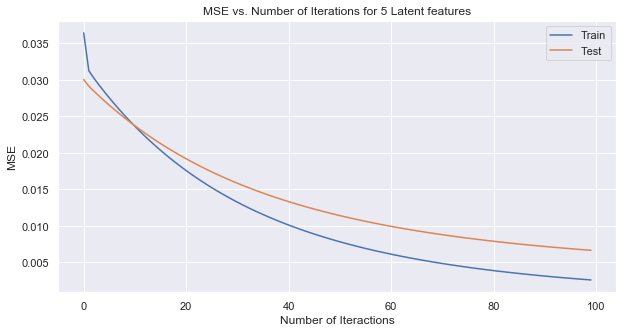

In [883]:
iters = 100
plt.plot(range(iters),mse_5,label='Train');
plt.plot(range(iters),test_mse_5,label='Test');

plt.xlabel('Number of Iteractions');
plt.ylabel('MSE');
plt.title('MSE vs. Number of Iterations for 5 Latent features');
plt.legend();

In [886]:
validation_new(user_item_train, user_mat_5, offer_mat_5)

0.0025880818227319424

In [891]:
test_mse_5[-1]

0.006657468236258464

## 2.2 Implement Funk SVD and fit to the training set for option 1

In [524]:
# Load user_item build on the training set
user_item_train_opt2 = pd.read_pickle("data/user_item_training_opt2.pkl").drop(labels=[0.0],axis=1)

In [525]:
train_data_np = np.array(user_item_train_opt2)

# Fit FunkSVD with the specified hyper parameters to the training data
user_mat_opt2, offer_mat_opt2,_ = FunkSVD(train_data_np, latent_features=15, learning_rate=0.005, iters=100)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.080042
21 		 0.022413
41 		 0.010085
61 		 0.005109
81 		 0.002822


In [526]:
user_mat_opt2_10, offer_mat_opt2_10,_ = FunkSVD(train_data_np, latent_features=10, learning_rate=0.005, iters=100)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.093338
21 		 0.022082
41 		 0.007678
61 		 0.003233
81 		 0.001523


In [527]:
user_mat_opt2_5, offer_mat_opt2_5,_ = FunkSVD(train_data_np, latent_features=5, learning_rate=0.005, iters=100)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.160408
21 		 0.015219
41 		 0.003123
61 		 0.000839
81 		 0.000247


## 3. Validation on the test set

### 3.1 Set up evaluation functions

In [843]:
# Load user_item build on the training set
user_item_test = pd.read_pickle("data/user_item_test_opt1.pkl")
user_item_test.shape

(9459, 10)

In [613]:
# Check for cold start problem

train_idx = user_item_train.index
test_idx = user_item_test.index
match_idx = list(test_idx.intersection(train_idx))

train_promo = set(user_item_train.columns)
test_promo =  set(user_item_test.columns)
match_cols = list(train_promo.intersection(test_promo))

cold_start_idx = np.setdiff1d(match_idx, list(test_idx), assume_unique=True)
print(len(cold_start_idx)) # No cold start issue
print(np.setdiff1d(match_cols, list(test_promo), assume_unique=True))

0
[]


In [856]:
# Function taken from the recommendation Lesson in Udacity Term2 and slightly adaptated 
def validation_new(user_item, user_mat, offer_mat,print_info =False):
    
    '''Measure the squared errors between the real values and the predicted values
    
    INPUT :
    - user_item (dataframe) : user-item dataframe
    - user_mat (array matrix)- user by latent factor matrix
    - offer_mat(array matrix)- latent factor by offer matrix
    
    OUPUT :
    - mse_error (float): mean squared error
    
    '''
    
    # Restrict the user-item dataframe to users and offers that have already been seen in the training set
    train_idx = user_item_train.index
    val_idx = user_item.index
    match_idx = list(train_idx.intersection(val_idx))
   
    train_promo = user_item_train.columns
    val_promo =  user_item.columns
    match_cols = list(train_promo.intersection(val_promo))
    
    user_item_val = user_item.loc[match_idx,match_cols]
    
    # Identify  the set of all ser and promo values available in the user_item_val dataframe
    val_idx = user_item_val.index
    val_promo =  user_item_val.columns
    
    # Restrict the user_mat and offer_mat matrices by filtering on the users and offers available in the test sets
    row_idxs = user_item_train.index.isin(val_idx)
    col_idxs = user_item_train.columns.isin(val_promo)
    user_mat_val = user_mat[row_idxs, :]
    offer_mat_val = offer_mat[:, col_idxs]
     
    # Initiate the value for accuracy metric items
    num_complete = np.count_nonzero(~np.isnan(user_item_val))
    sse_accum = 0
    #acc = []
    
    ## Make predictions
    n_users = user_item.shape[0]
    n_offer = user_item.shape[1]
    ratings_mat = np.array(user_item_val)  
    
    ## Loop through all the lines (users) and columns (offers) of the ratings_mat matrix
    for i in range(n_users):
        for j in range(n_offer):
            # Check that the value exists
            if ratings_mat[i, j] > 0:
            #if ~np.isnan(ratings_mat[i, j]):
                
                # compute the error as the actual minus the dot product of the user and movie latent features
                diff = ratings_mat[i, j] - np.dot(user_mat_val[i, :], offer_mat_val[:, j])
                
                # Keep track of the accuracy metrics
                #accuracy = 1-abs(diff)
                #acc.append()
                
                # Keep track of the sum of squared errors for the matrix
                sse_accum += diff**2

    # Normalize and print MSE
    mse_error = sse_accum/num_complete
    if print_info ==True :
        print('MSE on the set is: {}'.format(mse_error))

    return mse_error

### 3.2. Compute evaluation metrics for the different latent features values

In [615]:
# Evaluation for latent features of 15
validation_new(user_item_test, user_mat, offer_mat)

MSE on the set is: 0.003345977303334004


0.003345977303334004

In [616]:
validation_new(user_item_test, user_mat_10, offer_mat_10)

MSE on the set is: 0.0031410780509755765


0.0031410780509755765

In [617]:
validation_new(user_item_test, user_mat_5, offer_mat_5)

MSE on the set is: 0.001984652992540428


0.001984652992540428

### 3.3 Make recommendation based on Funk SVD prediction and top ranked offers for new users

In [619]:
# Function taken from the recommendation Lesson in Udacity Term2 and slightly adaptated 
def predict_FunkSVD(user_matrix, offer_matrix, user_id, offer_id):
    '''
    Predict behavior of user to a given offer based on its pasts interactions
    
    INPUT:
    user_matrix (array matrix)- user by latent factor matrix
    offer_matrix (array matrix)- latent factor by offer matrix
    user_id (str)- the user_id from the transcript dataframe
    offer_id (str)- the offer_id from the transcript dataframe
    
    OUTPUT:
    pred - the predicted reaction according to user-based collaborative filtering
    '''
    try:
        
        user_ids_series = np.array(user_item_train.index)
        offer_ids_series = np.array(user_item_train.columns)
  
        user_row = np.where(user_ids_series == user_id)[0][0]
        offer_col = np.where(offer_ids_series == offer_id)[0][0]
        
        # Take dot product of that row and column in U and V to make prediction
        pred = np.dot(user_matrix[user_row, :], offer_matrix[:, offer_col])
        
        return pred
    
    except:
        print("The prediction cannot be made for this user-promotion pair")
        return None

In [623]:
# Example of a prediction for an existing user : 
user_id="004b041fbfe44859945daa2c7f79ee64"
offer_id= "fafdcd668e3743c1bb461111dcafc2a4"
predict_FunkSVD(user_mat, offer_mat, user_id, offer_id)

1.0115618555089199

In [624]:
# Example of a prediction for an new user : 
user_id="new_user"
offer_id= "fafdcd668e3743c1bb461111dcafc2a4"
predict_FunkSVD(user_mat, offer_mat, user_id, offer_id)

The prediction cannot be made for this user-promotion pair


In [625]:
df_user_promotion_cycle_final_training.head()

,index,offer_id,creation_time,expiration_time,is_viewed,is_completed,mean_amount_spent,total_amount_spent,user_id,viewed_and_completed
0,0,ae264e3637204a6fb9bb56bc8210ddfd,0.0,168.0,1.0,NaN,2.293333,6.88,1e41c43e184e46759f01317e69f5cfcd,0
1,1,3f207df678b143eea3cee63160fa8bed,168.0,264.0,NaN,NaN,NaN,NaN,1e41c43e184e46759f01317e69f5cfcd,0
2,2,2906b810c7d4411798c6938adc9daaa5,336.0,504.0,NaN,NaN,NaN,NaN,1e41c43e184e46759f01317e69f5cfcd,0
3,3,f19421c1d4aa40978ebb69ca19b0e20d,504.0,624.0,1.0,1.0,8.350000,8.35,1e41c43e184e46759f01317e69f5cfcd,1
5,5,0,0.0,0.0,NaN,NaN,7.420000,14.84,1e41c43e184e46759f01317e69f5cfcd,0


In [925]:
def top_ranked_offer(user_promotion_cycle_final):
    '''
    Find the best offers in terms of ammount spent in the training set
    '''
    df_top_offers = user_promotion_cycle_final.groupby("offer_id")["total_amount_spent"].sum().sort_values(ascending=False)
    best_offer = user_promotion_cycle_final.groupby("offer_id")["total_amount_spent"].sum().sort_values(ascending=False)/df_top_offers.sum()
    return best_offer

# OLD

In [ ]:
# Function taken from the recommendation Lesson in Udacity Term2 and slightly adaptated 
def validation_old(user_item, user_mat, offer_mat):
    
    '''Measure the squared errors for the prediction
    INPUT :
    - user_item (dataframe) : user-item dataframe
    - user_mat (array matrix)- user by latent factor matrix
    - offer_mat(array matrix)- latent factor by offer matrix
    
    OUPUT :
    - mse_error (float): mean squared error
    
    '''
    num_complete = np.count_nonzero(~np.isnan(user_item))
    sse_accum = 0
    
    for user_id in user_item.index:
        for offer_id in user_item.columns:
            if ~np.isnan(user_item.loc[user_id, offer_id]):
               
                predict_value = predict_reaction(user_mat, offer_mat, user_id, offer_id)
                #predict_value = np.dot(user_mat[user_row, :], offer_mat[:, offer_col]) 
                 if predict_value != None:
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = user_item.loc[user_id, offer_id] - predict_value

                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    #acc.append(1- abs(diff))

    #deviding on the overall not null values in test_matrix
    mse_error = sse_accum/num_complete
    #acc_total = sum(acc)/num_complete
    
    print(sse_accum / num_complete)
    print('MSE on the set is: {}'.format(mse_error))
    #print('Accuracy on the set is : {}'.format(acc_total))
    
    return mse_error